In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform


# 1. Đọc dữ liệu

In [5]:
try: 
    train_data = pd.read_csv("../data/cleaned_data/train.csv")
    test_data = pd.read_csv("../data/cleaned_data/test.csv")
    val_data = pd.read_csv("../data/cleaned_data/val.csv")
    print("Read file success.")
    print("Train:", train_data.shape)
    print("Val:", val_data.shape)
    print("Test:", test_data.shape)
except Exception as e:
    print("Exception:", e)

Read file success.
Train: (1721, 23)
Val: (192, 23)
Test: (213, 23)


### Tách dữ liệu đầu vào, đầu ra

In [6]:
feature_cols = train_data.columns[:21]
X_train = train_data[feature_cols]
y_train_NSP = train_data['NSP']
y_train_CLASS = train_data['CLASS']

X_val = val_data[feature_cols]
y_val_NSP = val_data['NSP']
y_val_CLASS = val_data['CLASS']

X_test = test_data[feature_cols]
y_test_NSP = test_data['NSP']
y_test_CLASS = test_data['CLASS']

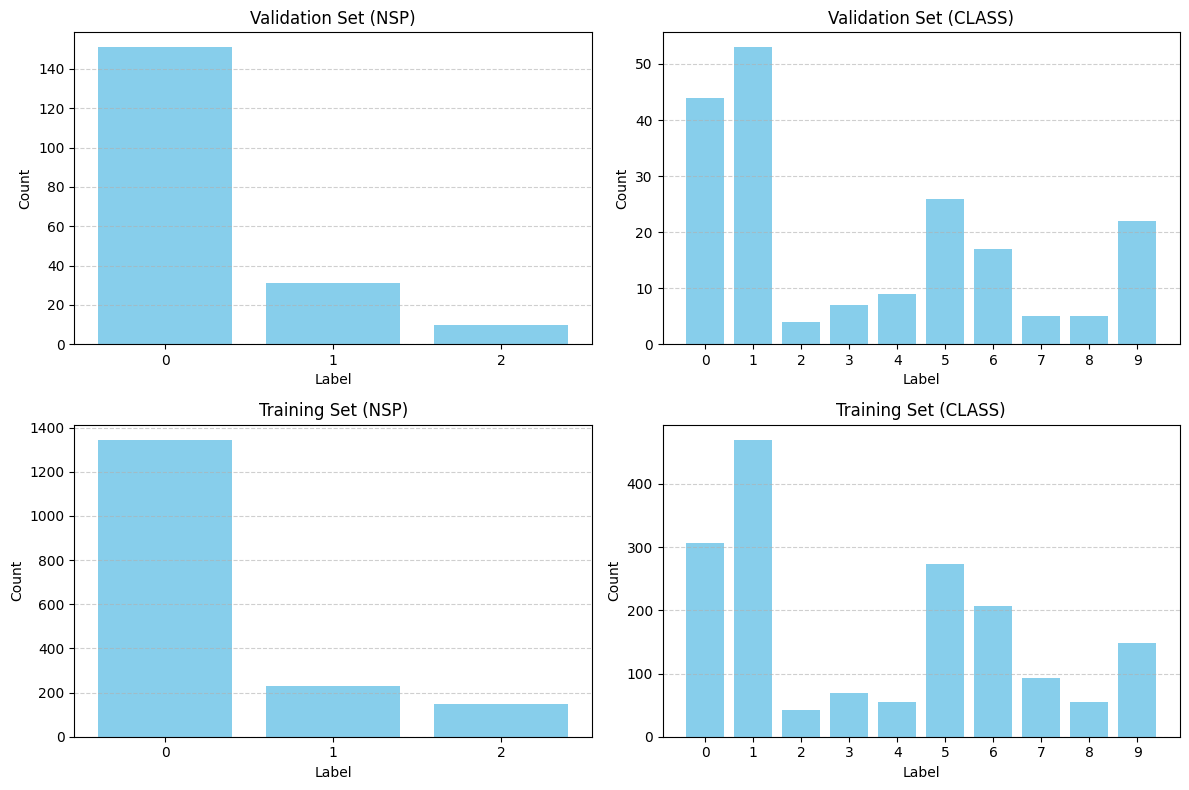

In [14]:
def get_label_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return unique, counts

distributions = [
    ("Validation Set (NSP)", *get_label_distribution(y_val_NSP)),
    ("Validation Set (CLASS)", *get_label_distribution(y_val_CLASS)),
    ("Training Set (NSP)", *get_label_distribution(y_train_NSP)),
    ("Training Set (CLASS)", *get_label_distribution(y_train_CLASS)),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

for i, (title, labels, counts) in enumerate(distributions):
    axs[i].bar(labels.astype(str), counts, color='skyblue')
    axs[i].set_title(title)
    axs[i].set_xlabel("Label")
    axs[i].set_ylabel("Count")
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 2. Pipeline xử lý dữ liệu

In [111]:
pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    # ('smote',   SMOTE(random_state=42)),
    ('mlp',     MLPClassifier(max_iter=500))
])

In [112]:
param_dist_NSP = {
    'mlp__hidden_layer_sizes': [(40,), (30,), (30, 20), (40, 20)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': uniform(0.001, 0.05),
    'mlp__learning_rate_init': uniform(0.001, 0.02)
}

# [(100,), (125,), (75,), (50, 50), (75, 25)]
# [(40,), (30,), (30, 20), (40, 20), (20, 15)]

param_dist_CLASS = {
    'mlp__hidden_layer_sizes': [(50,), (40,), (30,), (40, 30), (30, 20), (20, 20), (25, 25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': uniform(0.001, 0.05),
    'mlp__learning_rate_init': uniform(0.001, 0.02)
}

# [(50,), (40,), (30,), (40, 30), (30, 20), (20, 20), (25, 25)]
# [(100,), (125,), (75,), (50, 50), (75, 25), (80, 40), (100, 50)]
# [(50,), (60,), (75,), (50, 25), (60, 30)]

In [113]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Huấn luyện và đánh giá mô hình, có cross-validation


Gộp tập train và val

In [114]:
X_train_CV = np.concatenate([X_train, X_val])
y_train_CV_NSP = np.concatenate([y_train_NSP, y_val_NSP])
y_train_CV_CLASS = np.concatenate([y_train_CLASS, y_val_CLASS])

- NSP (3-class)

In [115]:
random_cv_NSP = RandomizedSearchCV(
    estimator   = pipe,
    param_distributions = param_dist_NSP,
    n_iter      = 200,
    cv          = cv,
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 2,
    random_state= 42
)
random_cv_NSP.fit(X_train_CV, y_train_CV_NSP)

print("Best params (CLASS, cross-validation):", random_cv_NSP.best_params_)
print("Best accuracy:", random_cv_NSP.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params (CLASS, cross-validation): {'mlp__activation': 'relu', 'mlp__alpha': np.float64(0.024885744544011386), 'mlp__hidden_layer_sizes': (40,), 'mlp__learning_rate_init': np.float64(0.01837198256378921)}
Best accuracy: 0.9367353355296434


In [116]:
# y_pred = pipe.predict(X_test)
best_cv_NSP = random_cv_NSP.best_estimator_
y_pred_cv_NSP = best_cv_NSP.predict(X_test)

print("TEST (NSP, cross-validation)")
print("Accuracy:", accuracy_score(y_test_NSP, y_pred_cv_NSP))
print(classification_report(y_test_NSP, y_pred_cv_NSP))
print(confusion_matrix(y_test_NSP, y_pred_cv_NSP))

TEST (NSP, cross-validation)
Accuracy: 0.9436619718309859
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       159
           1       0.80      0.89      0.84        36
           2       0.95      1.00      0.97        18

    accuracy                           0.94       213
   macro avg       0.91      0.95      0.93       213
weighted avg       0.95      0.94      0.94       213

[[151   8   0]
 [  3  32   1]
 [  0   0  18]]


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


- CLASS (10-class)

In [128]:
random_cv_CLASS = RandomizedSearchCV(
    estimator   = pipe,
    param_distributions = param_dist_CLASS,
    n_iter      = 200,
    cv          = cv,
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 2,
    random_state= 42
)
random_cv_CLASS.fit(X_train_CV, y_train_CV_CLASS)

print("Best params (CLASS, cross-validation):", random_cv_CLASS.best_params_)
print("Best accuracy:", random_cv_CLASS.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params (CLASS, cross-validation): {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.049589104136048036), 'mlp__hidden_layer_sizes': (40, 30), 'mlp__learning_rate_init': np.float64(0.005937521256772024)}
Best accuracy: 0.8609462359711838


In [129]:
best_cv_CLASS = random_cv_CLASS.best_estimator_
y_pred_cv_CLASS = best_cv_CLASS.predict(X_test)

print("TEST (CLASS, cross-validation)")
print("Accuracy:", accuracy_score(y_test_CLASS, y_pred_cv_CLASS))
print(classification_report(y_test_CLASS, y_pred_cv_CLASS))
print(confusion_matrix(y_test_CLASS, y_pred_cv_CLASS))

TEST (CLASS, cross-validation)
Accuracy: 0.9107981220657277
              precision    recall  f1-score   support

           0       0.85      0.82      0.84        34
           1       0.95      0.93      0.94        56
           2       0.80      0.67      0.73         6
           3       1.00      0.80      0.89         5
           4       0.88      0.88      0.88         8
           5       0.94      0.94      0.94        32
           6       0.90      1.00      0.95        28
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         9
           9       0.85      0.88      0.87        26

    accuracy                           0.91       213
   macro avg       0.92      0.89      0.90       213
weighted avg       0.91      0.91      0.91       213

[[28  1  1  0  0  0  0  0  0  4]
 [ 1 52  0  0  1  2  0  0  0  0]
 [ 2  0  4  0  0  0  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  0  0]
 [ 0  1  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# 4. Huấn luyện và đánh giá mô hình, validation thủ công

- NSP (3-class)

In [126]:
n_iter = 200
param_list = list(ParameterSampler({
    "hidden_layer_sizes": param_dist_NSP["mlp__hidden_layer_sizes"],
    "activation": param_dist_NSP["mlp__activation"],
    "alpha": param_dist_NSP["mlp__alpha"],
    "learning_rate_init": param_dist_NSP["mlp__learning_rate_init"]
}, n_iter=n_iter, random_state=42))

best_model_NSP = None
best_f1 = -1

from sklearn.metrics import f1_score

for params in param_list:
    model = MLPClassifier(
        max_iter=1000,
        random_state=42,
        **params
    )
    model.fit(X_train, y_train_NSP)
    
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val_NSP, y_val_pred, average='macro')
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_NSP = model
        best_params = params

print("Best validation macro F1:", best_f1)
print("Best params:", best_params)

Best validation macro F1: 0.9168196541853976
Best params: {'activation': 'relu', 'alpha': np.float64(0.031220868963890865), 'hidden_layer_sizes': (30, 20), 'learning_rate_init': np.float64(0.016111022770860975)}


In [127]:
y_pred_mv_NSP = best_model_NSP.predict(X_test)

print("TEST (CLASS, manual-validation)")
print("Accuracy:", accuracy_score(y_test_NSP, y_pred_mv_NSP))
print(classification_report(y_test_NSP, y_pred_mv_NSP))
print(confusion_matrix(y_test_NSP, y_pred_mv_NSP))


TEST (CLASS, manual-validation)
Accuracy: 0.9061032863849765
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       159
           1       0.76      0.69      0.72        36
           2       0.89      0.89      0.89        18

    accuracy                           0.91       213
   macro avg       0.86      0.85      0.85       213
weighted avg       0.90      0.91      0.90       213

[[152   7   0]
 [  9  25   2]
 [  1   1  16]]


- CLASS (10-class)

In [124]:
n_iter = 200
param_list = list(ParameterSampler({
    "hidden_layer_sizes": param_dist_CLASS["mlp__hidden_layer_sizes"],
    "activation": param_dist_CLASS["mlp__activation"],
    "alpha": param_dist_CLASS["mlp__alpha"],
    "learning_rate_init": param_dist_CLASS["mlp__learning_rate_init"]
}, n_iter=n_iter, random_state=42))

best_model_CLASS = None
best_f1 = -1

from sklearn.metrics import f1_score

for params in param_list:
    model = MLPClassifier(
        max_iter=1000,
        random_state=42,
        **params
    )
    model.fit(X_train, y_train_CLASS)
    
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val_CLASS, y_val_pred, average='macro')
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_CLASS = model
        best_params = params

print("Best validation macro F1:", best_f1)
print("Best params:", best_params)

Best validation macro F1: 0.8819380302399171
Best params: {'activation': 'tanh', 'alpha': np.float64(0.023472533706910173), 'hidden_layer_sizes': (50,), 'learning_rate_init': np.float64(0.002271167005720473)}


In [125]:
y_pred_mv_CLASS = best_model_CLASS.predict(X_test)

print("TEST (CLASS, manual-validation)")
print("Accuracy:", accuracy_score(y_test_CLASS, y_pred_mv_CLASS))
print(classification_report(y_test_CLASS, y_pred_mv_CLASS))
print(confusion_matrix(y_test_CLASS, y_pred_mv_CLASS))


TEST (CLASS, manual-validation)
Accuracy: 0.9014084507042254
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.96      0.91      0.94        56
           2       0.67      0.67      0.67         6
           3       1.00      1.00      1.00         5
           4       0.75      0.75      0.75         8
           5       0.94      0.97      0.95        32
           6       0.90      1.00      0.95        28
           7       0.90      1.00      0.95         9
           8       1.00      0.89      0.94         9
           9       0.88      0.81      0.84        26

    accuracy                           0.90       213
   macro avg       0.88      0.88      0.88       213
weighted avg       0.90      0.90      0.90       213

[[29  1  1  0  1  0  0  0  0  2]
 [ 0 51  1  0  1  2  1  0  0  0]
 [ 2  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0]
 [ 1  1  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  